In [3]:
###IMPORT MODULES
import numpy as np 
from tools.component_tools import Component
from tools.component_tools import Fluid
from tools.component_tools import Membrane
from tools.component_tools import GLC_Gas
from tools.component_tools import GLC 
from tools.materials import Flibe 
import tools.correlations as corr
import tools.materials as materials
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from scipy.optimize import fsolve
import matplotlib.lines as mlines
from tools.component_tools import BreedingBlanket

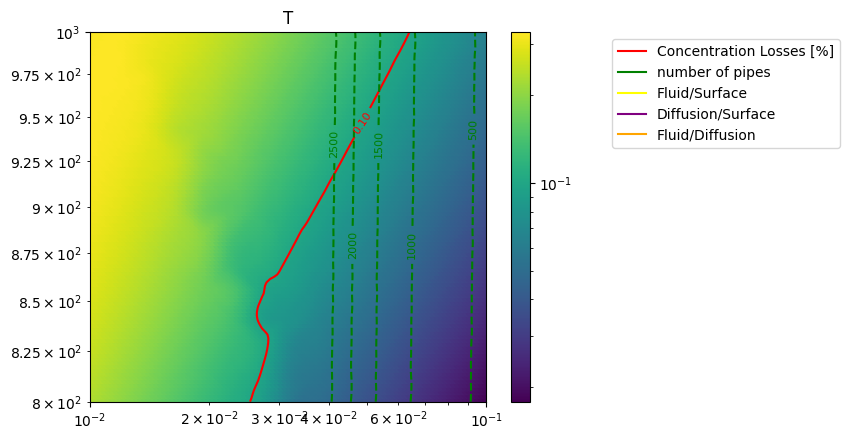

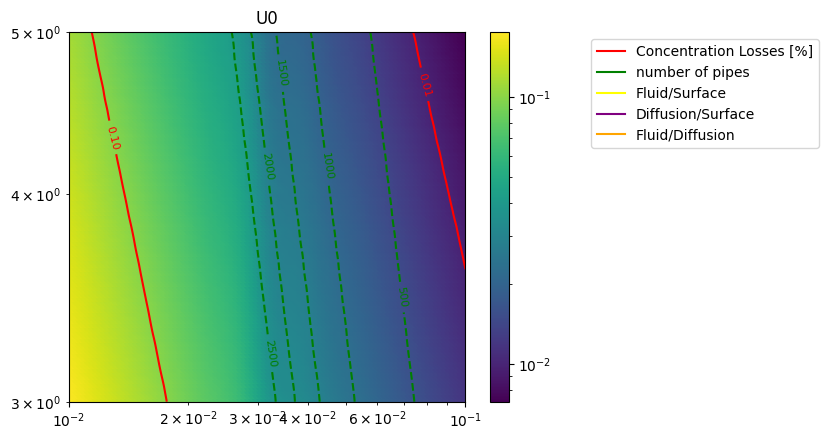

c:\Users\Gabriele\Desktop\fuel-cycle-python-1\tools\component_tools.py:364: RuntimeWarning: invalid value encountered in sqrt
  * (c_wl / self.fluid.Solubility) ** 0.5


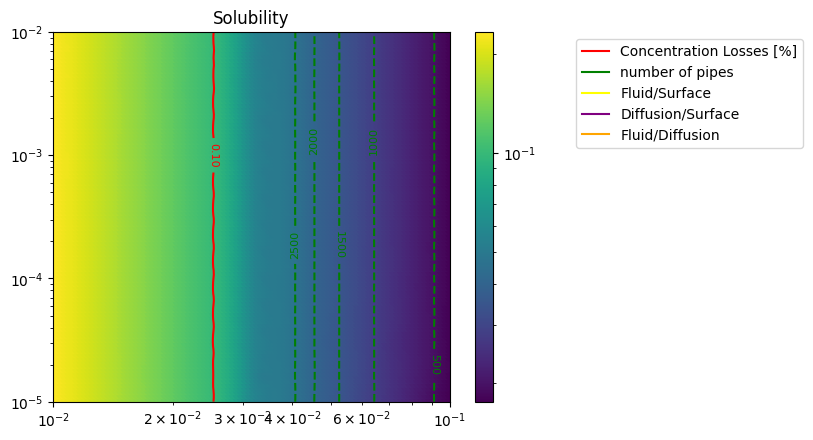

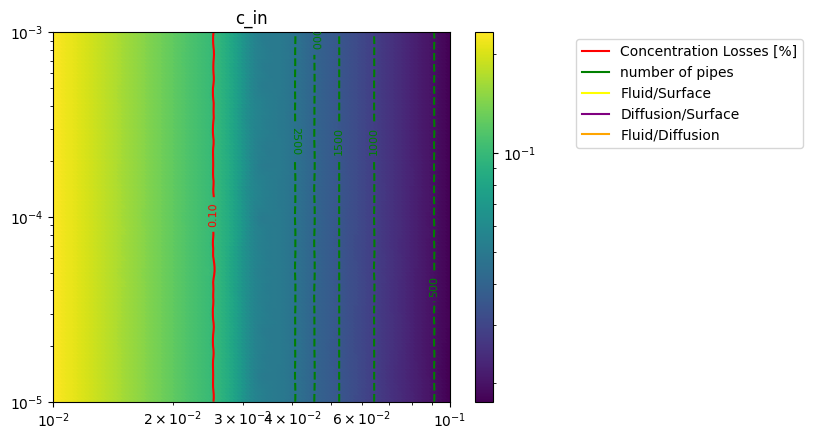

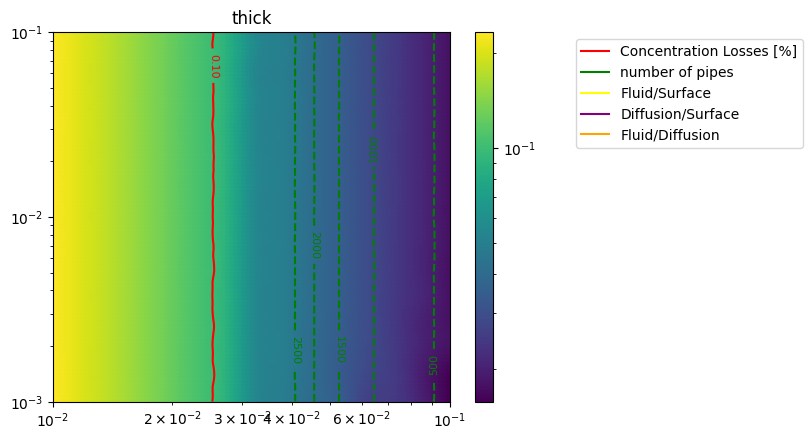

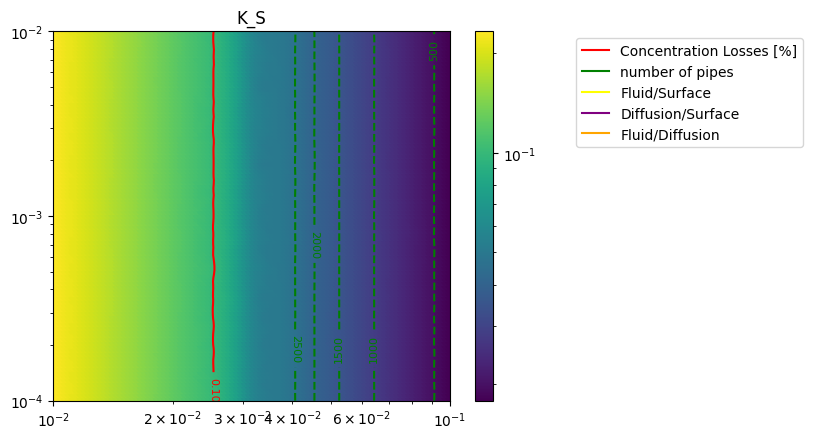

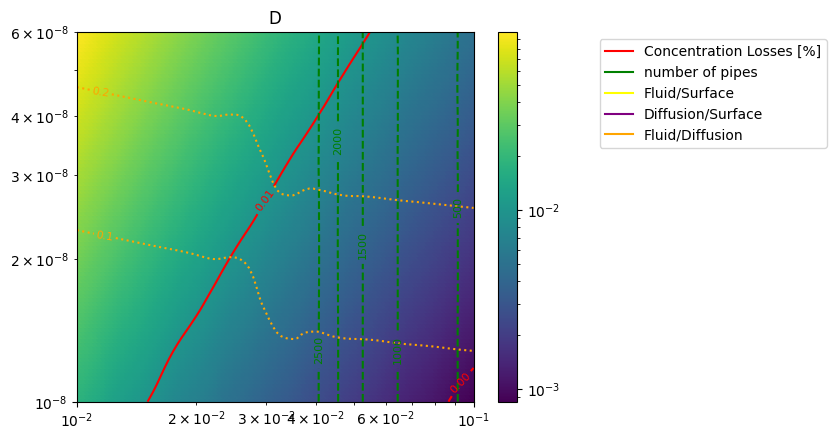

DeltaT_PAV: 1.9049473742547296


In [4]:
##Define sweep vectors
color_vector = ["red", "blue", "green", "yellow", "purple", "orange"]
Numvec=15
d_hyd_v=np.logspace(np.log10(1E-2),np.log10(10E-2),Numvec)
T_vec=np.linspace(800,1000,Numvec)
U0_vec=np.linspace(3, 5,Numvec)
str_v_vec=['T','U0','Solubility','c_in',"thick","K_S","D","k_d","k_r"]
c_in_vec=np.logspace(-5,-3,Numvec)
D_vec=np.logspace(np.log10(1E-8),np.log10(6E-8),Numvec)
thick_vec=np.logspace(-3,-1,Numvec)
K_S_vec=np.logspace(-4,-2,Numvec)
k_d_vec=np.logspace(2,6,Numvec)
k_r_vec=np.logspace(2,6,Numvec)
solubility_vec=np.logspace(-5,-2,Numvec)
v_vec=np.array([T_vec, U0_vec, solubility_vec, c_in_vec,  thick_vec, K_S_vec,D_vec])
eff_v_vec=np.array([])
fluid_v_bool=np.array([True , True , True ,False,False,False,False,False,False])
solid_v_bool=np.array([False, False, False,False,True ,True ,True ,True ,True ])
T_hot_prim=900
T_hot_sec=838
T_cold_prim=800
T_cold_sec=581
T_sec_ave=(T_hot_sec+T_cold_sec)/2
rho_sec=2263.628-0.636*T_sec_ave
mu_sec=0.075439-2.77E-4*(T_sec_ave-273.15)+3.49E-7*(T_sec_ave-273.15)**2-1.474E-10*(T_sec_ave-273.15)**3
k_sec=0.45
cp_sec=1396.044+0.172*(T_sec_ave)
N_HX=3
Q=1E9
m_in_sec=Q/(cp_sec*(T_hot_sec-T_cold_sec))
for j,vec in enumerate(v_vec):
        H_v=np.array([])
        W_v=np.array([])
        deltaT_PAV_vec=np.array([])
        W_vec=np.array([])
        H_vec=np.array([])
        eff_v=np.array([])
        var_str=str_v_vec[j]
        T=800
        res_vec=np.array([])
        d_hyd_v_res=np.array([])
        var_vec=np.array([])
        L_vec=np.array([])
        n_pipes_v=np.array([])
        for var in vec:
                for i,d_hyd in enumerate(d_hyd_v):
                        if str_v_vec[j]=='T':
                                T=var
                        mat=materials.Flibe(T)
                        
                        flibe=Fluid(T=T, Solubility=mat.Solubility, MS=True,D=mat.D, d_Hyd=d_hyd ,mu=mat.mu,rho=mat.rho,U0=2,k=mat.k,
                         cp=mat.cp)
                        BB=BreedingBlanket(Q=Q,TBR=1.08,T_out=T_hot_prim,T_in=T_cold_prim,fluid=flibe, c_in=0 )
                        BB.get_cout()
                        c0=BB.c_out
                        Steel = Membrane( T=T,
                                D=1E-3,
                                thick=2.1E-2,
                                K_S=4.41E-3,
                                k_d=1E6,
                                k_r=1E6,k=21)
                        PAV = Component(c_in=c0, eff=0.5, fluid=flibe, membrane=Steel)
                        if fluid_v_bool[j]==True:
                                PAV.fluid.update_attribute(var_str,var)
                        elif solid_v_bool[j]==True:
                                PAV.membrane.update_attribute(var_str,var)
                        else:
                                PAV.update_attribute(var_str,var)
                        n_pipes=BB.m_coolant/(PAV.fluid.rho*PAV.fluid.U0*PAV.fluid.d_Hyd**2/4)
                        Q_HX=Q/n_pipes/N_HX
                        HX=Component(c_in=PAV.outlet_c_comp(), eff=0.08, fluid=flibe)
                        PAV.get_adimensionals()
                        d_h_sec=2.5E-2 # from HX forecasts
                        V_sec=m_in_sec/(rho_sec*d_h_sec**2*np.pi/4)/N_HX/n_pipes
                        Re_sec=corr.Re(rho=rho_sec,u=V_sec,mu=mu_sec,L=d_h_sec)
                        Pr_sec=corr.Pr(c_p=cp_sec,mu=mu_sec,k=k_sec)
                        h_coeff_sec=corr.get_h_from_Nu(corr.Nu_DittusBoelter(Re_sec, Pr_sec), k_sec,d_h_sec)
                        R_sec=1/h_coeff_sec
                        U = PAV.get_global_HX_coeff(R_sec)
                        L=50
                        PAV.get_efficiency(L,plotvar=False)
                        PAV.analytical_efficiency(L)
                        # print("analitical eff",PAV.eff_an,"Eff",PAV.eff,'Efficiency diff:',PAV.eff-PAV.eff_an)
                        out_flux=(PAV.c_in*(1-PAV.eff)*PAV.fluid.U0*PAV.fluid.d_Hyd**2/4)
                        eff_v=np.append(eff_v, PAV.eff)
                        d_hyd_v_res=np.append(d_hyd_v_res, d_hyd)
                        var_vec=np.append(var_vec, var)
                        res_vec=np.append(res_vec, (PAV.eff-PAV.eff_an)/PAV.eff_an)
                        L_vec=np.append(L_vec, L)
                        n_pipes_v=np.append(n_pipes_v, n_pipes)
                        W_vec=np.append(W_vec, PAV.W)
                        H_vec=np.append(H_vec, PAV.H)
                        sigma_boltz=5.67E-8
                        deltaT_PAV=sigma_boltz*PAV.fluid.T**4*(PAV.fluid.d_Hyd*+PAV.membrane.thick)*2*np.pi*L*n_pipes*N_HX/(PAV.fluid.cp*BB.m_coolant)
                        deltaT_PAV_vec=np.append(deltaT_PAV_vec,deltaT_PAV)
                        H_v=np.append(H_v, PAV.H)
                        W_v=np.append(W_v, PAV.W)
                eff_v_vec=np.append(eff_v_vec, eff_v)
        plt.figure(j)
        plt.title(str_v_vec[j])
        x = np.logspace(np.log10(min(d_hyd_v_res[:])), np.log10(max(d_hyd_v_res[:])), num=100)
        y = np.logspace(np.log10(min(var_vec[:])), np.log10(max(var_vec[:])), num=100)
        X, Y = np.meshgrid(x, y)
        plt.yscale('log')
        plt.xscale('log')
        Z = griddata((d_hyd_v_res, var_vec), (res_vec)*100, (X, Y), method='cubic')
        ZL=griddata((d_hyd_v_res, var_vec), L_vec, (X, Y), method='cubic')
        Zn_pipes=griddata((d_hyd_v_res, var_vec), n_pipes_v, (X, Y), method='cubic')
        ZW=griddata((d_hyd_v_res, var_vec), W_v, (X, Y), method='cubic')
        ZH=griddata((d_hyd_v_res, var_vec), H_v, (X, Y), method='cubic')
        Zratio=griddata((d_hyd_v_res, var_vec), H_v/W_v, (X, Y), method='cubic')
        
        
        contour1=plt.contour(X, Y, Z, levels=[1E-4,1E-3,1E-2,1E-1,1,10,50,70],norm=LogNorm(),colors=color_vector[0])
        contour3=plt.contour(X, Y, Zn_pipes, levels=range(500,3000,500),colors=color_vector[2],linestyles='dashed')
        contour4=plt.contour(X, Y, ZH, levels=[0.1,0.2,10,20],colors=color_vector[3],linestyles='dotted')
        contour5=plt.contour(X, Y, ZW, levels=[0.1,0.2,10,20],colors=color_vector[4],linestyles='dotted')
        contour6=plt.contour(X, Y, Zratio, levels=[0.1,0.2,10,20],colors=color_vector[5],linestyles='dotted')
        #Z = np.ma.masked_where(Zn_pipes > 10000, Z)
        # Z = np.ma.masked_where(Z < 10, Z)
        scatter=plt.scatter(X,Y, c=Z ,norm=colors.LogNorm()) #,norm=colors.LogNorm()
        plt.clabel(contour1, inline=True, fontsize=8)
        plt.clabel(contour3, inline=True, fontsize=8)
        plt.clabel(contour4, inline=True, fontsize=8)
        plt.clabel(contour5, inline=True, fontsize=8)
        plt.clabel(contour6, inline=True, fontsize=8)
        line1 = mlines.Line2D([], [], color=color_vector[0], markersize=15, label='Concentration Losses [%]')
        line3 = mlines.Line2D([], [], color=color_vector[2], markersize=15, label='number of pipes')
        line4 = mlines.Line2D([], [], color=color_vector[3], markersize=15, label='Fluid/Surface')
        line5 = mlines.Line2D([], [], color=color_vector[4], markersize=15, label='Diffusion/Surface')
        line6= mlines.Line2D([], [], color=color_vector[5], markersize=15, label='Fluid/Diffusion')
        plt.legend(handles=[ line1, line3], loc='upper right')
        plt.legend(handles=[ line1, line3,line4,line5,line6], bbox_to_anchor=(1.3, 1), loc='upper left')
        if scatter:
                if np.nanmin(scatter.get_array()) < np.nanmax(scatter.get_array()):
                        plt.colorbar(scatter)  # Show color scale for scatter
                else:
                        print("Cannot create colorbar: data does not have a valid range of values.")
        plt.show()
sigma_boltz=5.67E-8
SUP_pipes=(PAV.fluid.d_Hyd*+PAV.membrane.thick)*2*np.pi*L*n_pipes*N_HX
deltaT_PAV=sigma_boltz*PAV.fluid.T**4*SUP_pipes/(PAV.fluid.cp*BB.m_coolant)
print('DeltaT_PAV:',deltaT_PAV)

In [5]:
from scipy.constants import R
tgen=BB.c_out*BB.m_coolant/BB.fluid.rho 
print(tgen)
T_He_in=300
T_He_out=800
T_He=T_He_out
K_H_He=1/R/T_He
p_He=1E-3 #bar
V_He=1
V_in_He=V_He/(np.pi/4*0.1**2)

rho_He=p_He*1E5/R/4/T_He
m_in_He=V_in_He*rho_He
c_He=tgen/(m_in_He/rho_He)
p_H2_he=c_He/K_H_He
print("concentration",c_He)
print("solubility",K_H_He)
print("density",rho_He)
print("pressure",p_H2_he)
print("pressureBB",BB.c_out/BB.fluid.Solubility)
cp_He=5.19 ## TODO
Q_He=(T_He_out-T_He_in)*m_in_He*cp_He
deltaT_He_flibe=Q_He/(BB.m_coolant*BB.fluid.cp)
print("deltaT_He_flibe",deltaT_He_flibe)
print(R)
print("V_He",V_He)
print("Re_He",corr.Re(rho=rho_He,u=V_He,mu=0.000018,L=0.1))
print("V_He",V_in_He)
print("mass flow rate he", m_in_He)



0.0006359892743615426
concentration 4.995048080240315e-06
solubility 0.0001503404438061784
density 0.00375851109515446
pressure 0.03322491243061661
pressureBB 0.6760430943806703
deltaT_He_flibe 0.00012418333459980575
8.314462618
V_He 1
Re_He 20.880617195302555
V_He 127.32395447351627
mass flow rate he 0.4785484955676522


In [6]:
PAV.inspect()
print(n_pipes)
PAV.fluid.inspect()
PAV.membrane.inspect()
BB.inspect()
print(PAV.J_perm)

c_in: 0.0003069235648488243
eff: 0.015244634577256898
fluid is a <class 'tools.component_tools.Fluid'> class, printing its variables:
T: 800
Solubility: 0.000454
MS: True
D: 1.6829270990116207e-09
k_t: 3.597901634146433e-05
d_Hyd: 0.1
mu: 0.012674408885334595
rho: 2022.6
U0: 2
k: 1.1
cp: 2386
membrane is a <class 'tools.component_tools.Membrane'> class, printing its variables:
T: 800
D: 6.000000000000003e-08
thick: 0.021
k_d: 1000000.0
K_S: 0.00441
k_r: 1000000.0
k: 21
H: 61220216553494.61
W: 130510856861206.19
c_out: 0.00015346178242441215
U: 488.52528551713834
J_perm: -9.311742905581529e-09
zeta: 0.9239156914583222
tau: 0.035979016341464325
eff_an: 0.01524388638318297
414.42844225714634
T: 800
Solubility: 0.000454
MS: True
D: 1.6829270990116207e-09
k_t: 3.597901634146433e-05
d_Hyd: 0.1
mu: 0.012674408885334595
rho: 2022.6
U0: 2
k: 1.1
cp: 2386
T: 800
D: 6.000000000000003e-08
thick: 0.021
k_d: 1000000.0
K_S: 0.00441
k_r: 1000000.0
k: 21
c_in: 0
Q: 1000000000.0
TBR: 1.08
T_out: 900
T_i